## Test: dK/dt

In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.signal import argrelextrema
from datetime import datetime

# Custom
# import functions as f

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'ibt_vars2keep':    ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_r50', 'usa_r64', 'usa_rmw', 'storm_speed', 'storm_dir', 'name', 'sid'],
    'ibt_info2keep':    ['sid', 'basin', 'name', 'usa_atcf_id', 'usa_agency', 'iso_time', 'usa_status'],
    'vars_of_interest': ['wind_speed', 'lon', 'lat', 'track_vmax', 'distance_to_coast', 'cyclone_speed', 'cyclone_speed_std', 'rotation_angle', 'rotation_angle_std', 
                         'vmax', 'rmax', 'tco_radii_ms_all', 'tco_radii_ms_FR', 'tco_radii_ms_FL', 'tco_radii_ms_RR', 'tco_radii_ms_RL', 'cyclone_category'],
    
    # 'save_figs':        False,
}

PTHS = {
    # 'data_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    # 'dsg_pth':          '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    # 'dsg2_pth':         '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_17102022_with_extra_params.nc',
    # 'save_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_STEADY_STATE_CRIT/02_VMAX_B_RELATION/',
    'ibt_pth': '/home/arthur/data/ibtracs/IBTrACS.ALL.v04r00.nc'
}

In [3]:
# Open IBTrACS
ds_ibt_raw = xr.open_dataset(PTHS['ibt_pth'])
ds_ibt     = ds_ibt_raw[PRMS['ibt_vars2keep']]
ds_ibt[PRMS['ibt_info2keep']] = ds_ibt_raw[PRMS['ibt_info2keep']].astype(str, copy=False) # Convert byte arrays to strings

start_date = np.datetime64('2009-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, None))

In [4]:
### CONVERSIONS
# Convert to m/s and km units
for speed in ['usa_wind', 'storm_speed']:
    ds_ibt[speed]  *= 0.5144
for radius in ['usa_r34', 'usa_r50', 'usa_r64', 'usa_rmw']:
    ds_ibt[radius] *= 1.852

In [5]:
# Basics
vmx           = ds_ibt.usa_wind # m/s
r34           = ds_ibt.mean(dim='quadrant', skipna=True).usa_r34 * 1000 # m
ds_ibt['IKE'] = (vmx * r34) ** 2

# Intensification and growing rates in IBTrACS
# vmx_dot_smth = ds_ibt.usa_wind.rolling(date_time=4).mean().differentiate(coord='date_time') / 3                                         # m/s/hr
# r34_dot_smth = ds_ibt.usa_r34.mean(dim='quadrant', skipna=True).rolling(date_time=4).mean().differentiate(coord='date_time') * 1000 / 3 # m/hr

vmx_dot_smth = ds_ibt.usa_wind.rolling(date_time=4, center=True, min_periods=2).mean().differentiate(coord='date_time') / 3                                         # m/s/hr
r34_dot_smth = ds_ibt.usa_r34.mean(dim='quadrant', skipna=True).rolling(date_time=4, center=True, min_periods=2).mean().differentiate(coord='date_time') * 1000 / 3 # m/hr

# Kinetic Energy
ds_ibt['dKdt']  = (1 / 3600) * 2 * (r34 * vmx) * (vmx_dot_smth * r34 + r34_dot_smth * vmx)
ds_ibt['dKdt2'] = (1 / 3600) * ds_ibt.IKE.rolling(date_time=4).mean().differentiate(coord='date_time') / 3 

In [22]:
# sam.dKdt.plot()
# (sam.IKE.differentiate(coord='date_time') / (3 * 3600)).plot(c='r')

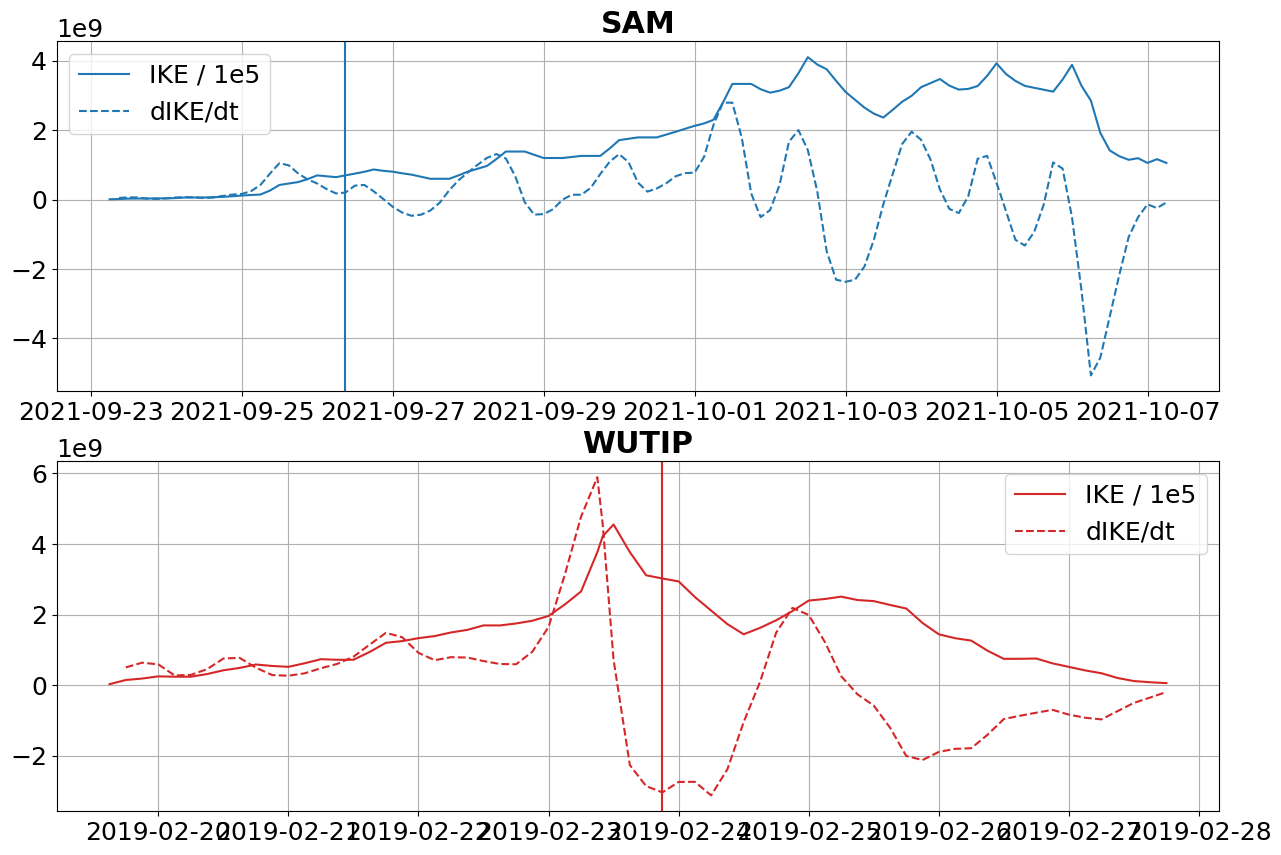

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

# SAM
sam   = ds_ibt.where(ds_ibt.name == 'SAM', drop=True).isel(storm=0)
ax1.set_title('SAM', weight='bold')
ax1.plot(sam.time,   sam.IKE / 1e5, c='tab:blue', label='IKE / 1e5')
ax1.plot(sam.time,   sam.dKdt,      c='tab:blue', label='dIKE/dt', linestyle='--')
# ax1.plot(sam.time,   sam.dKdt2,     c='k',        label='dIKE/dt version 2', linestyle='--')
ax1.axvline(sam.isel(date_time=29).time.values) # SAR S1B
ax1.legend();ax1.grid()

# WUTIP
wutip = ds_ibt.where(ds_ibt.name == 'WUTIP', drop=True).isel(storm=1)
ax2.set_title('WUTIP', weight='bold')
ax2.plot(wutip.time, wutip.IKE / 1e5, c='tab:red',  label='IKE / 1e5')
ax2.plot(wutip.time, wutip.dKdt,      c='tab:red',  label='dIKE/dt', linestyle='--')
# ax2.plot(wutip.time, wutip.dKdt2,     c='k',        label='dIKE/dt version 2', linestyle='--')
ax2.axvline(wutip.isel(date_time=44).time.values, c='tab:red') # SAR S1B
ax2.legend();ax2.grid()

In [ ]:
sam.usa_wind.plot(c='tab:blue')
wutip.usa_wind.plot(c='tab:red')
plt.grid()
plt.show()
(sam.usa_r34.mean(dim='quadrant', skipna=True) * 1000).plot(c='tab:blue')
(wutip.usa_r34.mean(dim='quadrant', skipna=True) * 1000).plot(c='tab:red')
plt.grid()

In [ ]:
# for s in range(len(ds_ibt.storm))[:100]:
#     ds = ds_ibt.isel(storm=s)
#     plt.title('{}'.format(s), weight='bold')
#     plt.plot(ds.time,   ds.IKE / 1e5, c='tab:blue', )
#     plt.plot(ds.time,   ds.dKdt,      c='tab:blue', linestyle='--')
#     plt.grid();plt.show()